(pyfreqtracker_sqlite)=

# Tracking mutations over time using `sqlite3`

:::{note}
This is an advanced vignette.
It shows off how powerful it is to have access to the entire Python world of data packages during a simulation.
This vignette uses low-level [sqlite](https://www.sqlite.org) syntax as well as higher-level Python libraries.
:::

## Introduction

The previous vignette tracking mutation frequencies was straightforward to implement.
However, using {class}`dict` to key {class}`list`s of frequencies risks running out of memory.

This vignette reimplements the previous method using much more powerful techniques:

* Instead of the {class}`dict`, we record data into fixed-length {class}`numpy.ndarray` objects.
* During the simulation, we preserve all individuals of each generation as ancient samples.  
  See {ref}`here <recorders_vignette>` for background.
  The trick is that we will only keep these ancient samples until the table collection is simplified!
* We populate those arrays immediately after simplification.
  We use the `post_simplification_recorder` argument to {func}`fwdpy11.evolvets`, passing in a class that gets frequencies from the tree sequences.
  Once our callback is finished, the ancient samples are purged.
* When the `numpy` arrays get full, we transfer their data to a relational database using the {mod}`sqlite3` module that is built in to the Python language.
  We will take advantage of the {class}`pandas.DataFrame` function {meth}`pandas.DataFrame.to_sql`, which can transfer in-memory data to `SQL` databases via a convenient `API`.


We will need the following imports:

In [1]:
import attr
import sqlite3 

import fwdpy11
import numpy as np
import pandas as pd

We need to implement two Python classes.
The first will handle the mechanics of recording the ancient samples themselves.
This class is trivial (see {ref}`here <recorders_vignette>` for background):

## Helper types

In [2]:
class SampleEveryone(object):
    def __call__(self, pop, sampler):
        sampler.assign(np.arange(pop.N, dtype=np.uint32))

The second class will be a callable that gets executed immediately after simplification.
This type is responsible for processing trees, getting data into `numpy` arrays, and transferring the data to the database.

This class has a lot of responsibilities.
In order to shorten the code, we define a `TableBuffer` class that holds the `numpy` arrays and handles the mechanics of calling {meth}`pandas.DataFrame.to_sql`.
The definition of this class is shown below, and you may click to see it.

In [3]:
@attr.s(auto_attribs=True, kw_only=True)
class TableBuffer(object):
    max_records: int

    def __attrs_post_init__(self):
        self.num_records = 0
        self.generation = np.zeros(self.max_records, dtype=np.uint32)
        self.origin_time = np.zeros(self.max_records, dtype=np.uint32)
        self.position = np.zeros(self.max_records, dtype=np.float64)
        self.frequency = np.zeros(self.max_records, dtype=np.float64)
        self.effect_size = np.zeros(self.max_records, dtype=np.float64)

    def update(
        self,
        conn,
        *,
        generation,
        origin_time,
        position,
        frequency,
        effect_size,
    ):
        self.generation[self.num_records] = generation
        self.origin_time[self.num_records] = origin_time
        self.position[self.num_records] = position
        self.frequency[self.num_records] = frequency
        self.effect_size[self.num_records] = effect_size
        self.num_records += 1

        if self.num_records == self.max_records:
            self._flush_buffer(conn)

    def _flush_buffer(self, conn):
        if self.num_records == 0:
            return

        df = pd.DataFrame(
            {
                "generation": self.generation[: self.num_records],
                "origin_time": self.origin_time[: self.num_records],
                "position": self.position[: self.num_records],
                "frequency": self.frequency[: self.num_records],
                "effect_size": self.effect_size[: self.num_records],
            }
        )
        df.to_sql(
            "trajectories_temp",
            conn,
            if_exists="append",
            index=False,
            method="multi",
            chunksize=25000,
        )
        self.num_records = 0

We also have two simple helper classes.
We will use them to not record the frequencies of fixed mutations over and over again, as well as to record when a mutation did reach fixation.

In [4]:
@attr.s(auto_attribs=True, kw_only=True, frozen=True)
class MutationKey(object):
    origin_time: int
    position: float
    effect_size: float


@attr.s(auto_attribs=True, kw_only=True, frozen=True)
class FixationRecord(object):
    fixation_time: int

## A class to track mutations frequencies via a database

Now, we define `CountMutations`, which is our real workhorse.
The `__call__` function takes an instance of {class}`fwdpy11.DiploidPopulation` as an argument.
When this function is called, the {attr}`fwdpy11.DiploidPopulation.tables` will be indexed, allowing us to visit trees using {class}`fwdpy11.TreeIterator`.

This class also contains several "boiler plate" functions to handle data transfer to the database.
We follow the Python tradition of using function names beginning with an underscore to indicate that these functions are not intended to be part of the public interface to this class.

:::{note}
This example uses an in-memory `SQL` database named `:memory:`.
(See {func}`sqlite3.connect` for details.)
We use this approach because this example may be run on a cloud server.
In practice, it is much more efficient to use an on-disk database!
Doing so requires some simple modifications that are left as an "exercise for the reader".
:::

On a first read, you probably want to skip all of the underscore functions and focus on the details of `__call__`.
This function uses {meth}`fwdpy11.DiploidPopulation.sample_timepoints` to iterate over the ancient samples based on their birth times.
For each cohort of ancient samples, we simplify the tables with respect to that sample using {func}`fwdpy11.simplify_tables`.
We then iterate over all the trees, using {class}`fwdpy11.TreeIterator`, to obtain the number of samples with each mutation via {func}`fwdpy11.TreeIterator.leaf_counts`.

The implementation details of `__call__` are offloaded to another function.
The reason is that we need to avoid double-counting mutations!
When the tables are simplified, they are simplified with respect to the ancestry of all samples nodes, both "alive" and "ancient".
Because we are preserving every generation, our current alive nodes will soon become ancient samples.
Thus, to avoid double counting, we do **not** process the currently-alive generation.
To make sure that we do, eventually, get all mutations counted, we need to call our `count_em_up` function at the end of the simulation for final tallying.

In [5]:
@attr.s(auto_attribs=True)
class CountMutations(object):
    """
    This is run only in generations where simplification happens.
    Tables are indexed and "ready to roll" for analysis.
    """
    max_records: int

    def __attrs_post_init__(self):
        self.buffer = TableBuffer(max_records=self.max_records)
        self.num_records = 0
        self.fixations: typing.Dict = dict()
        self.conn = sqlite3.connect(":memory:")

    def _dump_fixations(self):
        origin_time = []
        effect_size = []
        position = []
        fixation_times = []
        for k, v in self.fixations.items():
            origin_time.append(k.origin_time)
            effect_size.append(k.effect_size)
            position.append(k.position)
            fixation_times.append(v.fixation_time)

        df = pd.DataFrame(
            {
                "origin_time": origin_time,
                "effect_size": effect_size,
                "position": position,
                "fixation_time": fixation_times,
            }
        )
        df.to_sql("fixations_temp", self.conn, if_exists="replace", index=False)
        self.fixations = dict()

    def _dump_remaining_data(self):
        self.buffer._flush_buffer(self.conn)
        self._dump_fixations()

    def finalize_database(self):
        """
        Be sure to call this at the end of a simulation!
        """
        self._dump_remaining_data()
        self.conn.execute(
            "create table mutations (origin_time int, position real, effect_size real, id integer primary key autoincrement)"
        )
        self.conn.commit()
        self.conn.execute(
            """
            insert into mutations select origin_time, position, effect_size, NULL
            from
            trajectories_temp
            group by origin_time, position, effect_size
            """
        )
        self.conn.commit()
        self.conn.execute(
            """
            create table trajectories
            as
            select mutations.id, trajectories_temp.generation,
            trajectories_temp.frequency
            from
            trajectories_temp
            left join mutations
            on trajectories_temp.origin_time == mutations.origin_time
            and trajectories_temp.position == mutations.position
            and trajectories_temp.effect_size == mutations.effect_size
            """
        )
        self.conn.execute("drop table trajectories_temp")
        self.conn.execute(
            """
            create table fixations
            as
            select mutations.id, fixations_temp.fixation_time
            from fixations_temp
            left join mutations
            on fixations_temp.origin_time == mutations.origin_time
            and fixations_temp.position == mutations.position
            and fixations_temp.effect_size == mutations.effect_size
            """
        )
        self.conn.execute("drop table fixations_temp")
        self.conn.commit()

        # indexes speed up cross-table analysis
        self.conn.execute("create index traj_id_index on trajectories(id)")
        self.conn.execute("create index fixation_id_index on fixations(id)")
        self.conn.execute("create index mutation_id_index on mutations(id)")
        self.conn.execute("vacuum")
        self.conn.commit()

    def count_em_up(self, pop, *, include_alive):
        """
        We implement the mechanics of __call__ separately,
        so that they may be re-used to process alive nodes
        when evolvets returns.
        """
        for generation, nodes, metadata in pop.sample_timepoints(
            include_alive=include_alive
        ):
            # non-owning view
            w = metadata["w"][:]
            tables, idmap = fwdpy11.simplify_tables(pop.tables, nodes)
            tv = fwdpy11.TreeIterator(tables, idmap[nodes])
            for t in tv:
                for m in t.mutations():
                    key = MutationKey(
                        origin_time=pop.mutations[m.key].g,
                        position=pop.mutations[m.key].pos,
                        effect_size=pop.mutations[m.key].s,
                    )
                    if key not in self.fixations:
                        s = t.leaf_counts(m.node)
                        assert s > 0
                        freq = s / (2.0 * pop.N)
                        if freq == 1.0:
                            self.fixations[key] = FixationRecord(
                                fixation_time=generation
                            )
                        self.buffer.update(
                            self.conn,
                            generation=generation,
                            origin_time=key.origin_time,
                            position=key.position,
                            frequency=freq,
                            effect_size=key.effect_size,
                        )

    def __call__(self, pop):
        self.count_em_up(pop, include_alive=False)

We now run the same simulation as in in the previous vignette.
The differences are:

* An instance of `SampleEveryone` is our recorder.
* An instance of `CountMutations` is passed to `post_simplification_recorder`
* We simplify every 100 generations instead of every generation.

In [6]:
pdict = {
    # Add a region for neutral mutations:
    "nregions": [fwdpy11.Region(0, 1, 1)],
    "sregions": [fwdpy11.ExpS(beg=0, end=1, weight=1, mean=0.2)],
    "recregions": [fwdpy11.PoissonInterval(0, 1, 1e-2)],
    "gvalue": [fwdpy11.Multiplicative(2.0)],
    # Add a mutation rate for neutral mutations:
    "rates": (5e-3, 1e-3, None),
    "simlen": 100,
}
params = fwdpy11.ModelParams(**pdict)
pop = fwdpy11.DiploidPopulation(100, 1.0)
rng = fwdpy11.GSLrng(54321)
recorder = SampleEveryone()
counter=CountMutations(max_records=100)
fwdpy11.evolvets(
    rng,
    pop,
    params,
    100,  # Simplify every 100 generations
    recorder,
    suppress_table_indexing=False,
    post_simplification_recorder=counter
)

As mentioned earlier, we have to run a couple of extra functions now to make sure we process all of our data:

In [7]:
# Get data from the final generation
counter.count_em_up(pop, include_alive=True)

counter.finalize_database()

We are going to use {func}`pandas.read_sql` to pull data from our database into {class}`pandas.DataFrame` objects.
Our approach here is not optimal and we discuss alternatives below.

In [8]:
traj = pd.read_sql('select * from trajectories', counter.conn)
mut = pd.read_sql('select * from mutations', counter.conn)
df = pd.merge(traj, mut, how='left', on=['id'])
df['neutral'] = [i == 0.0 for i in df.effect_size]

Finally, let us plot our output:

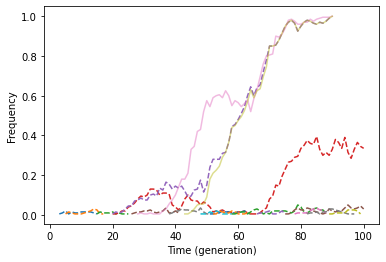

In [9]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()

for n, g in df.groupby(['id', 'neutral']):
    if len(g.index) >= 10:
        linestyle = '-'
        alpha=1.0
        if n[1] is True:
            linestyle='--'
        else:
            alpha=0.5
        ax.plot(g.generation, g.frequency, linestyle=linestyle, alpha=alpha)
ax.set_xlabel("Time (generation)")
ax.set_ylabel("Frequency");

The figure should be identical to {numref}`pyfreqtrackfigneutral`.

## Details of the implementation

What are all the underscore methods doing?
They are all called by `finalize_database`, which is to be run at the end of a simulation.

The operations are:

* Create a `mutations` table in our database.
  We populate this table based on unique `(position, effect size, origin time)` combinations in our temporary trajectories.
  This table has an automatically incrementing column that assigns a unique integer `ID` to each combination.
  This unique integer will be a "mutation `ID`".
* We can now create our final trajectories table that is populated with the mutation `ID`, generation in the simulation and frequency.
  Thus, the redundant information is removed.
* We create a `fixations` table that also uses these `ID` values.
* Finally, we create index columns for the `ID` values for each table.
  These indexes will greatly speed up analysis.

The use of all of this is to both save space on disk and to speed up analysis.

## Further considerations

Like the previous vignette, this recipe needs adjustment for the following cases:

* Tracking mutation frequencies with respect to deme.
* Tracking mutation frequencies in demes that change size.
* When processing the databases, it is best to do as much as possible at the level of `SQL` itself and not pull everything into a data frame like we did above.
  For on-disk databases, `R`'s [dbplyr](https://dbplyr.tidyverse.org/) package will generally be the best tool here.
  Yes, this means changing languages.
  But, you get to use the same syntax as "regular" [dplyr](https://dplyr.tidyverse.org/) for most of your analyses.
  Most importantly, by having `dbplyr` execute your analysis on the `SQL` side, you can analyze massive data sets that you could not possible hold in memory.
  You can plot the output using `R` or use any of a variety of methods to get your processed data back into Python for plotting.